In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data 102 Fall 2025, Lecture 9

## Warmup

As a warmup, consider a pair of random variables $(x_1, x_2)$ drawn uniformly from the unit circle. In other words, we want the uniform distribution over the blue region below.

Suppose we want to compute var$(x_2)$.

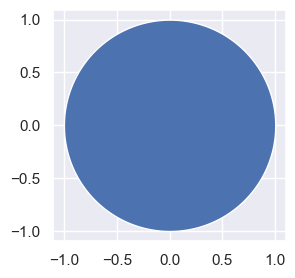

In [2]:
x_ = np.linspace(-1, 1, 1000)
semicircle = np.sqrt(1-x_**2)
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.fill_between(x_, -semicircle, semicircle)
ax.axis('equal');

In [3]:
# Number of samples
N = 20

# Samples in the unit square
samples = np.random.uniform(-1, 1, [N, 2])
samples


array([[-0.71916064,  0.12308493],
       [-0.9415483 , -0.5589459 ],
       [-0.56672653,  0.28636246],
       [ 0.24288138,  0.97156446],
       [-0.74242348, -0.509696  ],
       [-0.47713077, -0.72468783],
       [-0.84811678, -0.10745639],
       [-0.76467263,  0.81798952],
       [-0.88411888, -0.04329978],
       [-0.80245455, -0.0078658 ],
       [-0.2490543 , -0.30994228],
       [ 0.01094951,  0.28273939],
       [ 0.60047862,  0.69281468],
       [ 0.78236541, -0.28724336],
       [-0.1528232 ,  0.9934415 ],
       [ 0.85692893, -0.36196724],
       [ 0.5948401 ,  0.94044726],
       [-0.67362787,  0.08860337],
       [ 0.37209251, -0.1935489 ],
       [-0.8257778 , -0.10163047]])

Variance of x1 (estimated from samples): 0.238


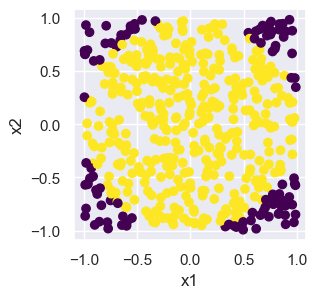

In [4]:
# Number of samples
N = 500

# Samples in the unit square
samples = np.random.uniform(-1, 1, [N, 2])

# Which ones are inside the unit circle?
is_in_circle = (samples[:,0]**2 + samples[:, 1]**2) < 1

f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(samples[:, 0], samples[:, 1], c=is_in_circle, cmap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.axis('equal')

good_samples = samples[is_in_circle]
x1 = good_samples[:, 0]
x2 = good_samples[:, 1]
print('Variance of x1 (estimated from samples): %.3f' % np.var(x1))

## Rejection sampling

Suppose we want to sample from the distribution with density 

$$
p(\theta|x) \propto \theta \cdot (1.5-\theta) \cdot \sin(\theta), \theta \in [0,1.5]
$$

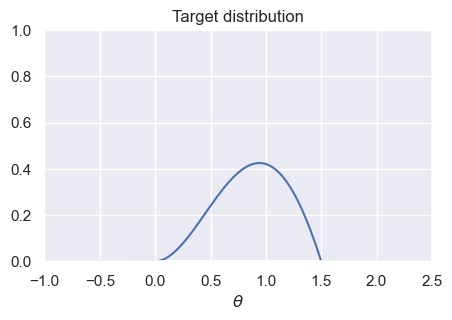

In [5]:
t = np.linspace(-1, 2.5, 500)
def target(t):
    """The unnormalized distribution we want to sample from"""
    return t * (1.5-t) * np.sin(t) * ((t > 0) & (t < 1.5))
f, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, target(t))
ax.set_title('Target distribution')
ax.set_xlabel(r'$\theta$')
ax.axis([-1,2.5,0,1]);

How can we make this look like the geometric example from before? We'll generate samples from a uniform distribution, and throw some away at random (instead of deterministically like in the previous example).

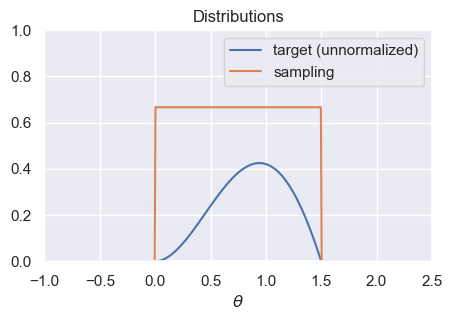

In [6]:
x = np.linspace(-1, 2.5, 500)
def uniform_sampling_dist(t):
    """PDF of distribution we're sampling from: Uniform[0, 1.5]"""
    return stats.uniform.pdf(t, 0, 1.5)

f, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, target(t), label='target (unnormalized)')
ax.plot(t, uniform_sampling_dist(t), label='sampling')
ax.axis([-1,2.5,0,1])
ax.legend()
ax.set_title('Distributions')
ax.set_xlabel(r'$\theta$');

In [7]:
def rejection_sample_uniform(num_samples=100):
    # Generate proposals for samples: these are θ-values.
    # We'll keep some and reject the rest.
    proposals = np.random.uniform(low=0, high=1.5, size=num_samples)
    
    # Acceptance probability is the ratio of the two curves
    # These had better all be between 0 and 1!
    accept_probs = target(proposals) / uniform_sampling_dist(proposals)
    
    print('Max accept prob: %.3f' % np.max(accept_probs))
    
    # For each sample, we make a decision whether or not to accept.
    # Convince yourself that this line makes that decision for each
    # sample with prob equal to the value in "accept_probs"!
    accept = np.random.uniform(size=num_samples) < accept_probs
    
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]

Max accept prob: 0.638
Accepted 33 out of 100 proposals


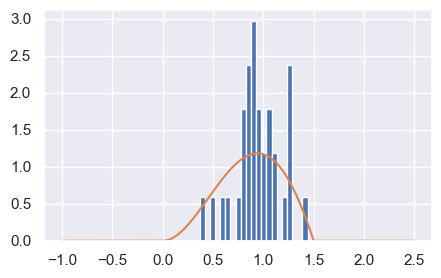

In [8]:
samples = rejection_sample_uniform(num_samples=100)
f, ax = plt.subplots(1, 1, figsize=(5, 3))
# Plot a true histogram (comparable with density functions) using density=True
ax.hist(samples, bins=np.linspace(-0.5, 2, 50), density=True)

# Where did this magic number 0.36 come from? What happens if you change it?
ax.plot(t, target(t) / 0.36)

### Target distribution with infinite support

Accepted 53 out of 100 proposals


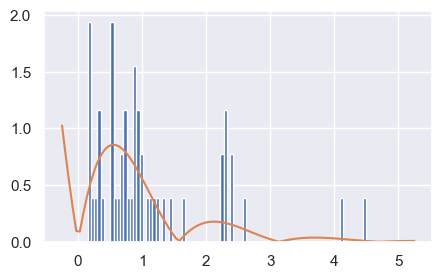

In [9]:
def decaying_target_distribution(t):
    """Unnormalized target distribution as described above"""
    return np.exp(-t) * np.abs(np.sin(2*t))

def sampling_distribution_exponential(t):
    """Sampling distribution: exponential distribution"""
    # stats.expon has a loc parameter which says how far to shift
    # the distribution from its usual starting point of θ=0
    return stats.expon.pdf(t, loc=0, scale=1.0)

def rejection_sample_exponential(num_samples=100):
    proposals = np.random.exponential(scale=1.0, size=num_samples)
    
    accept_probs = (
        decaying_target_distribution(proposals)
        / sampling_distribution_exponential(proposals)
    )
    accept = np.random.uniform(0, 1, num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]
samples = rejection_sample_exponential(num_samples=100)
f, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(samples, bins=np.linspace(0, 5, 100), density=True)
# Find how far the axis goes and draw the unnormalized distribution over it

tmin, tmax, _, _ = plt.axis()
t_inf = np.linspace(tmin, tmax, 100)

# Where did this magic number 0.6 come from? What happens if you change it?
ax.plot(t_inf, decaying_target_distribution(t_inf) / 0.6)
